## Scale Testing
- In this note, we will check how the estimation results change with changes in the scale of the donor pool features.
- Adding donor pools with extremely different scales (e.g., 10x), as in the following experiment, can have a significant impact (bias) on the estimates

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

### setup & base model

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit(zeta_type="base")

In [3]:
print("ATT : ", sdid.hat_tau())

ATT :  -15.603523730845872


<class 'pandas.core.indexes.base.Index'> (19,)
<class 'numpy.ndarray'> (19,)
Index([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988],
      dtype='int64')
[8.95604259e-06 6.60389197e-06 5.35261139e-06 4.36931630e-06
 3.35573592e-06 1.27620312e-06 0.00000000e+00 0.00000000e+00
 1.38272414e-09 2.71334676e-09 6.68036229e-09 1.06539880e-08
 1.54929763e-08 1.71786671e-08 2.32571948e-08 2.44292131e-08
 3.67184692e-01 2.05244166e-01 4.27589182e-01]


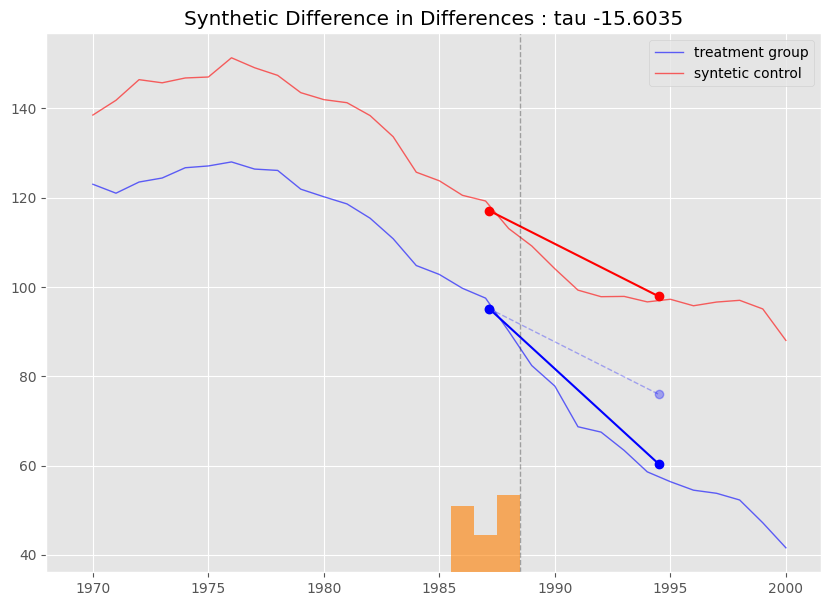

In [4]:
sdid.plot()

## unit weight (omega)
- The weight is relatively concentrated in `Nevada` & `New Hampshire`, and when plotted, it certainly seems to be moving in parallel with the treatment group (California). 

In [5]:
hat_omega_sdid, _ = sdid.estimated_params()

cm = sns.light_palette("green", as_cmap=True)
hat_omega_sdid.query("features != 'intercept' & sdid_weight >0").sort_values(
    by="sdid_weight", ascending=False
).style.background_gradient(cmap=cm)

,features,sdid_weight
19,Nevada,0.124000
20,New Hampshire,0.105000
3,Connecticut,0.078000
4,Delaware,0.070000
2,Colorado,0.057000
7,Illinois,0.053000
18,Nebraska,0.048000
17,Montana,0.045000
32,Utah,0.042000
21,New Mexico,0.041000


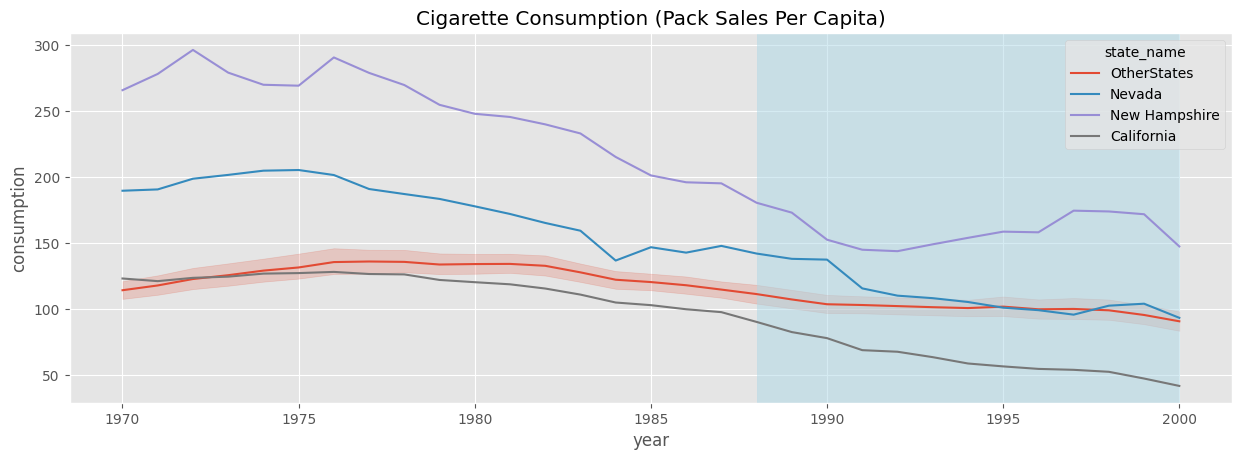

In [6]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["state_name"] = np.where( melt_df["state"] == "California", "California", "OtherStates")
melt_df.loc[melt_df["state"] == "Nevada", "state_name"] =  "Nevada"
melt_df.loc[melt_df["state"] == "New Hampshire", "state_name"] =  "New Hampshire"

fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="state_name", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## test 1 : Nevada

In [7]:
expand_list = [0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 10, 50, 100]

In [8]:
nevada_omega = {}
nevada_tau = {}

for _e in tqdm(expand_list):
    if _e != 1:
        _df = df.copy()
        _df["Nevada"] = _df["Nevada"] * _e
        # re-run
        _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
        _sdid.fit(zeta_type="base")

        nevada_tau[_e] = _sdid.hat_tau()
        hat_omega_sdid, _ = _sdid.estimated_params()

    else:
        nevada_tau[_e] = sdid.hat_tau()
        hat_omega_sdid, _ = sdid.estimated_params()

    nevada_omega[_e] = hat_omega_sdid.query("features == 'Nevada'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


In [9]:
nevada_tau = pd.DataFrame(nevada_tau, index = ["tau"]).T
nevada_omega = pd.DataFrame(nevada_omega, index = ["weight"]).T

In [10]:
_expand_list = [ str(_e) for _e in expand_list ]

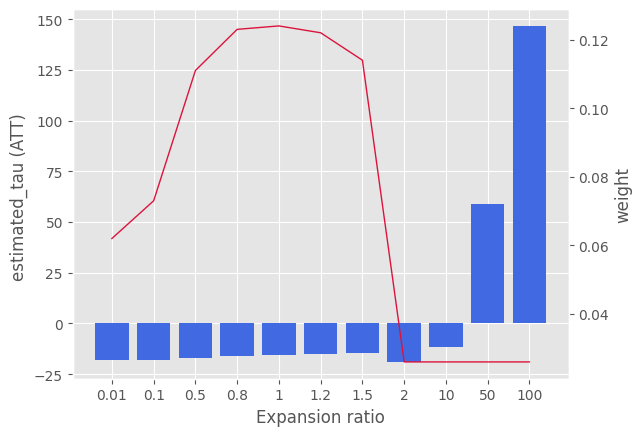

In [11]:
fig, ax1 = plt.subplots()
ax1.bar(_expand_list , nevada_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , nevada_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [12]:
nevada_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-17.827648,-17.812903,-17.122206,-16.209848,-15.603524,-15.088267,-14.453964,-18.944724,-11.526604,58.795649,146.698466


In [13]:
nevada_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.062,0.073,0.111,0.123,0.124,0.122,0.114,0.026,0.026,0.026,0.026


## test 2 : New Hampshire

In [14]:
new_hampshire_omega = {}
new_hampshire_tau = {}

for _e in tqdm(expand_list):
    if _e != 1:
        _df = df.copy()
        _df["New Hampshire"] = _df["New Hampshire"] * _e
        # re-run
        _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
        _sdid.fit(zeta_type="base")

        new_hampshire_tau[_e] = _sdid.hat_tau()
        hat_omega_sdid, _ = _sdid.estimated_params()

    else:
        new_hampshire_tau[_e] = sdid.hat_tau()
        hat_omega_sdid, _ = sdid.estimated_params()

    new_hampshire_omega[_e] = hat_omega_sdid.query("features == 'New Hampshire'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


In [15]:
new_hampshire_tau = pd.DataFrame(new_hampshire_tau, index = ["tau"]).T
new_hampshire_omega = pd.DataFrame(new_hampshire_omega, index = ["weight"]).T

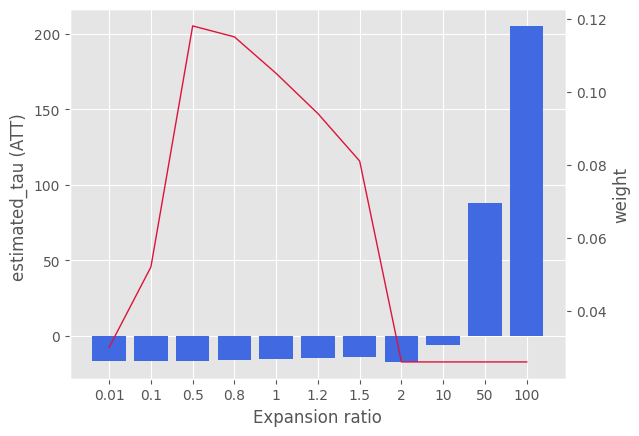

In [16]:
fig, ax1 = plt.subplots()
ax1.bar(_expand_list , new_hampshire_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , new_hampshire_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [17]:
new_hampshire_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-16.656273,-17.034599,-16.990626,-16.16211,-15.603524,-15.0033,-14.295219,-17.40369,-6.205966,87.763565,205.22548


In [18]:
new_hampshire_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.03,0.052,0.118,0.115,0.105,0.094,0.081,0.026,0.026,0.026,0.026


# log preprocessing 

In [19]:
ln_df = df.apply(np.log)
ln_sdid = SynthDID(ln_df, PRE_TEREM, POST_TEREM, TREATMENT)
ln_sdid.fit(zeta_type="base")

In [20]:
print("ATT : ", ln_sdid.hat_tau())

ATT :  -0.2858071050319335


<class 'pandas.core.indexes.base.Index'> (19,)
<class 'numpy.ndarray'> (19,)
Index([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988],
      dtype='int64')
[3.95982995e-17 2.32483101e-17 1.75274855e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.98970462e-17 2.74694476e-17
 0.00000000e+00 4.84125689e-18 1.13639816e-20 6.95451246e-18
 5.42528978e-02 0.00000000e+00 3.26348662e-17 5.15546579e-17
 6.62469437e-02 2.48308972e-01 6.31191186e-01]


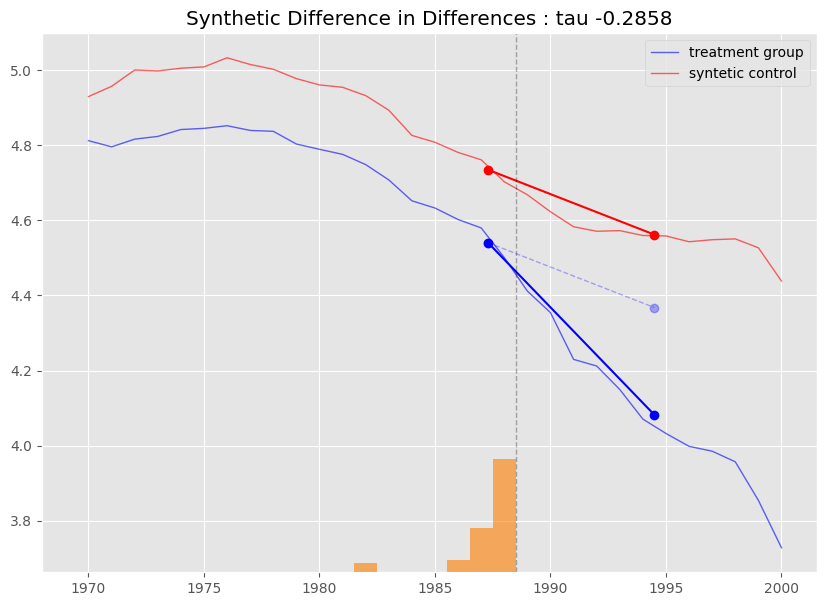

In [21]:
ln_sdid.plot()

In [22]:
hat_omega_sdid_ln, _ = ln_sdid.estimated_params()

cm = sns.light_palette("green", as_cmap=True)
hat_omega_sdid_ln.query("features != 'intercept' & sdid_weight >0").sort_values(
    by="sdid_weight", ascending=False
).style.background_gradient(cmap=cm)

,features,sdid_weight
20,New Hampshire,0.166000
19,Nevada,0.158000
2,Colorado,0.087000
17,Montana,0.082000
22,North Carolina,0.079000
3,Connecticut,0.058000
7,Illinois,0.052000
6,Idaho,0.050000
4,Delaware,0.049000
18,Nebraska,0.042000


In [23]:
ln_nevada_omega = {}
ln_nevada_tau = {}

for _e in tqdm(expand_list):
    _df = df.copy()
    _df["Nevada"] = _df["Nevada"] * _e

    # log
    _df = _df.apply(np.log)
    # re-run
    _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
    _sdid.fit(zeta_type="base")

    ln_nevada_tau[_e] = _sdid.hat_tau()
    hat_omega_sdid, _ = _sdid.estimated_params()
    ln_nevada_omega[_e] = hat_omega_sdid.query("features == 'Nevada'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


In [24]:
ln_nevada_tau = pd.DataFrame(ln_nevada_tau, index = ["tau"]).T
ln_nevada_omega = pd.DataFrame(ln_nevada_omega, index = ["weight"]).T

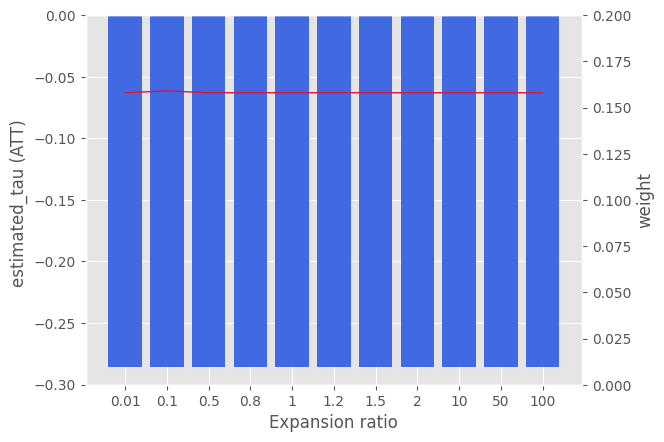

In [25]:
fig, ax1 = plt.subplots()
ax1.bar(_expand_list , ln_nevada_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , ln_nevada_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)
ax2.set_ylim(0 , 0.2)

plt.show()